In [1]:
from datetime import date, datetime, timezone, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pytz

# Target Variable
## USGS Site AEK201
Site [AEK201](https://cida.usgs.gov/ngwmn/provider/WAECY/site/100018881/) is a well monitored by the Washington State Department of Ecology.

In [2]:
## Load raw data
level_data = pd.read_csv('../data-collection/data/EIM-data-AEK201/EIMTimeSeriesResults_2023Oct22_222975.csv',
                         low_memory=False)

In [3]:
## Restrict the data to rows where Result_Parameter_Name=='Water level in well (depth below measuring point)'
level_data = level_data.loc[level_data['Result_Parameter_Name']=='Water level in well (depth below measuring point)']
level_data = level_data.rename(columns={'Result_Value':'well_depth'})

In [4]:
## Restrict our attention to the Field_Collection_Date_Time, Result_Value, and Time_Zone columns
level_data = level_data[['Field_Collection_Date_Time','well_depth','Time_Zone']]

In [5]:
## Construct a localized timestame for each measurment and store it in a datetime_recorded column
tz_dict = {'PDT - Pacific Daylight Time (GMT-7)':'Etc/GMT-7', 
           'PST - Pacific Standard Time (GMT-8)':'Etc/GMT-8'}

level_data['Time_Zone']=level_data['Time_Zone'].apply(lambda x: tz_dict[x])

level_data['Field_Collection_Date_Time'] = pd.to_datetime(
    level_data['Field_Collection_Date_Time'], format = '%m/%d/%Y %H:%M:%S %p', utc=False)

times = level_data.Field_Collection_Date_Time.values
zones = level_data.Time_Zone.values
localized_times = []
for time, zone in zip(times, zones):
    localized_times.append(pd.Timestamp(time).tz_localize(zone))

level_data['datetime_recorded'] = localized_times

## Sort by the timestamps
level_data = level_data.sort_values('datetime_recorded')
level_data = level_data.reset_index(drop=True)

In [6]:
## Extract the date to a column
level_data['date'] = level_data['datetime_recorded'].dt.date

# Checking for missing values or outliers
Here we:
- Look at some information about the data
- Check for missing values
    - Decide how to handle missing values
- Check for outliers
    - Investigate outliers

In [7]:
level_data.describe()

,Field_Collection_Date_Time,well_depth
count,103423,103423.000000
mean,2011-11-02 09:30:29.917909760,66.631503
min,2005-08-22 01:00:00,54.960100
25%,2008-11-21 06:00:00,64.885685
50%,2011-11-04 02:00:00,67.650000
75%,2014-10-16 10:00:00,69.120000
max,2017-09-28 12:00:00,71.200000
std,NaN,3.331441


In [8]:
level_data.dtypes

Field_Collection_Date_Time               datetime64[ns]
well_depth                                      float64
Time_Zone                                        object
datetime_recorded             datetime64[ns, Etc/GMT-7]
date                                             object
dtype: object

In [9]:
level_data.isna().sum()

Field_Collection_Date_Time    0
well_depth                    0
Time_Zone                     0
datetime_recorded             0
date                          0
dtype: int64

## Handling missing values:

There are no obvious missing values.

In [10]:
## How many well_depth measurments more than 2 standard deviations above the mean?
level_data.loc[level_data.well_depth > 66.631503+2*3.331441]['well_depth'].count()

0

In [11]:
## How many well_depth measurments more than 2 standard deviations below the mean?
level_data.loc[level_data.well_depth < 66.631503-2*3.331441]['well_depth'].count()

4422

In [12]:
## How many well_depth measurments more than 3 standard deviations below the mean?
level_data.loc[level_data.well_depth < 66.631503-3*3.331441]['well_depth'].count()

965

In [13]:
## How many well_depth measurments more than 4 standard deviations below the mean?
level_data.loc[level_data.well_depth < 66.631503-4*3.331441]['well_depth'].count()

0

In [14]:
## What do extreme values look like?
pd.set_option('display.max_rows', 191)
level_data.loc[level_data.well_depth < 66.631503-2*3.331441].groupby('date').describe()

Field_Collection_Date_Time                                 \
                                count                           mean   
date                                                                   
2008-05-19                         18            2008-05-19 07:10:00   
2008-05-20                         24            2008-05-20 06:30:00   
2008-05-21                         24            2008-05-21 06:30:00   
2008-05-22                         24            2008-05-22 06:30:00   
2008-05-23                         24            2008-05-23 06:30:00   
2008-05-24                         24            2008-05-24 06:30:00   
2008-05-25                         24            2008-05-25 06:30:00   
2008-05-26                         24            2008-05-26 06:30:00   
2008-05-27                         24            2008-05-27 06:30:00   
2008-05-28                         24            2008-05-28 06:30:00   
2008-05-29                         24            2008-05-29 06:30:00   
2008-05-30                         24            2008-05-30 06:30:00   
2008-05-31                         24            2008-05-31 06:30:00   
2008-06-01                         24            2008-06-01 06:30:00   
2008-06-02                         24            2008-06-02 06:30:00   
2008-06-03                         24            2008-06-03 06:30:00   
2008-06-04                         24            2008-06-04 06:30:00   
2008-06-05                         24            2008-06-05 06:30:00   
2008-06-06                         24            2008-06-06 06:30:00   
2008-06-07                         24            2008-06-07 06:30:00   
2008-06-08                         24            2008-06-08 06:30:00   
2008-06-09                         24            2008-06-09 06:30:00   
2008-06-10                         24            2008-06-10 06:30:00   
2008-06-11                         24            2008-06-11 06:30:00   
2008-06-12                         24            2008-06-12 06:30:00   
2008-06-13                         24            2008-06-13 06:30:00   
2008-06-14                         24            2008-06-14 06:30:00   
2008-06-15                         24            2008-06-15 06:30:00   
2008-06-16                         24            2008-06-16 06:30:00   
2008-06-17                         24            2008-06-17 06:30:00   
2008-06-18                         24            2008-06-18 06:30:00   
2008-06-19                         24            2008-06-19 06:30:00   
2008-06-20                         24            2008-06-20 06:30:00   
2008-06-21                         24            2008-06-21 06:30:00   
2008-06-22                         24            2008-06-22 06:30:00   
2008-06-23                         24            2008-06-23 06:30:00   
2008-06-24                         24            2008-06-24 06:30:00   
2008-06-25                         24            2008-06-25 06:30:00   
2008-06-26                         12            2008-06-26 06:30:00   
2011-04-09                          9            2011-04-09 07:00:00   
2011-04-10                         24            2011-04-10 06:30:00   
2011-04-11                         20            2011-04-11 06:15:00   
2011-05-16                         10            2011-05-16 06:30:00   
2011-05-17                         24            2011-05-17 06:30:00   
2011-05-18                         24            2011-05-18 06:30:00   
2011-05-19                         24            2011-05-19 06:30:00   
2011-05-20                         24            2011-05-20 06:30:00   
2011-05-21                         24            2011-05-21 06:30:00   
2011-05-22                         24            2011-05-22 06:30:00   
2011-05-23                         24            2011-05-23 06:30:00   
2011-05-24                         24            2011-05-24 06:30:00   
2011-05-25                         24            2011-05-25 06:30:00   
2011-05-26                         24            20

## Handling outliers

There are no well measurments that excede two standard devistions above the mean. The measurments that occur more than two standard deviations below the mean occur around the followign dates:

- 2008-05-19 through 2008-06-26
- 2011-04-09 through 2011-04-11
- 2011-05-17 through 2011-06-27
- 2012-04-06 through 2012-04-10
- 2012-04-24 through 2012-05-24
- 2012-06-13 through 2012-06-20
- 2017-03-18 through 2017-05-04
- 2017-05-08 through 2017-05-19

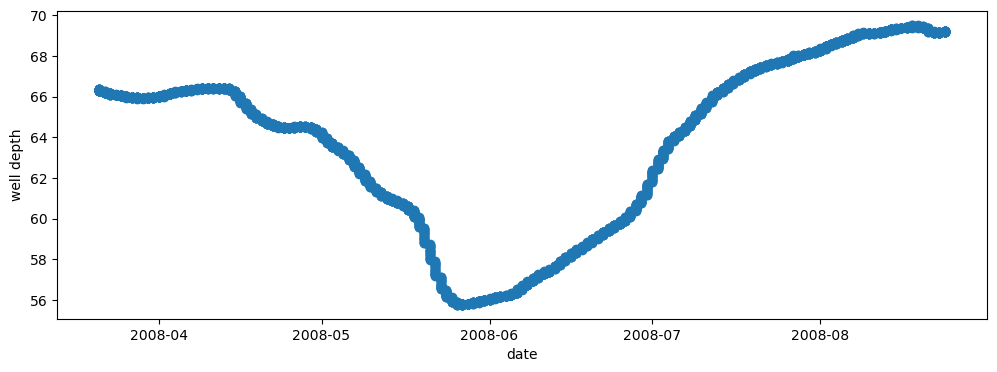

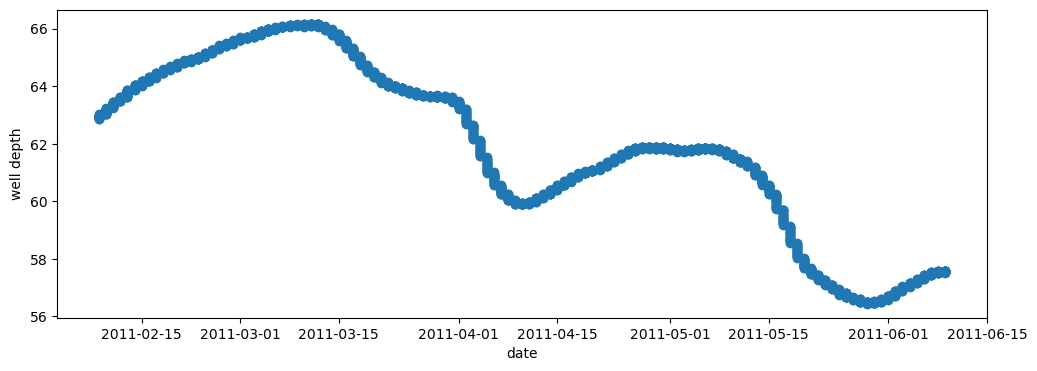

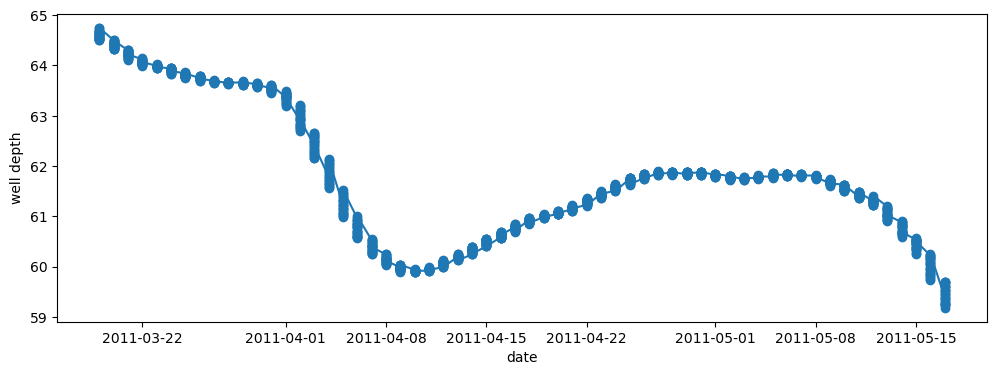

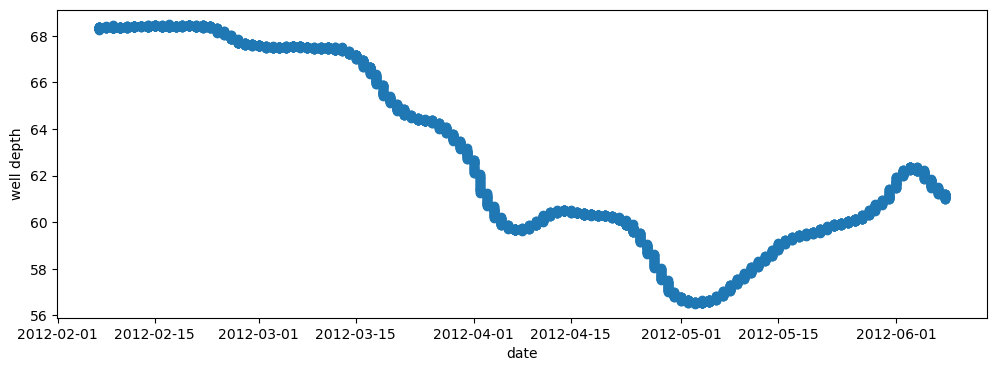

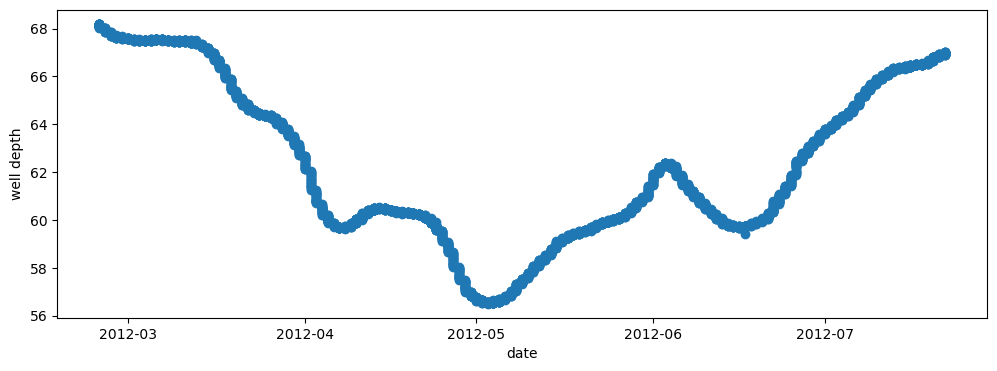

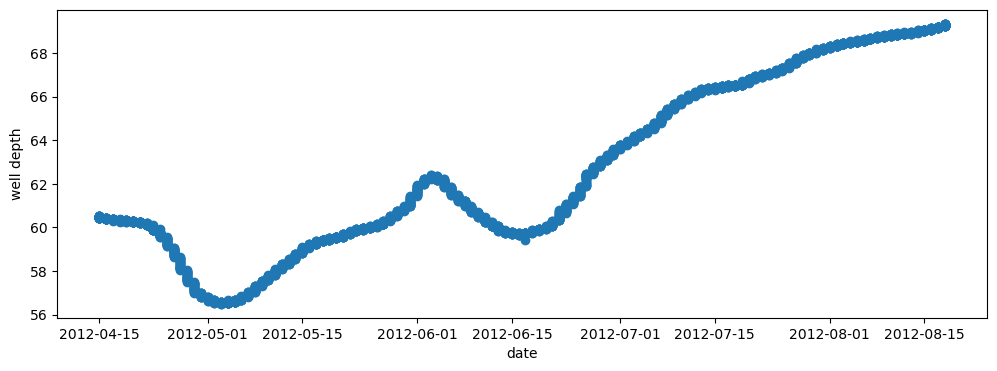

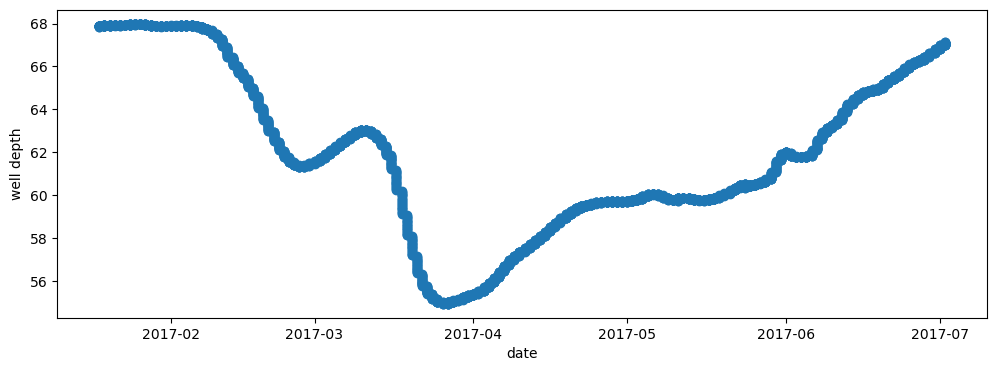

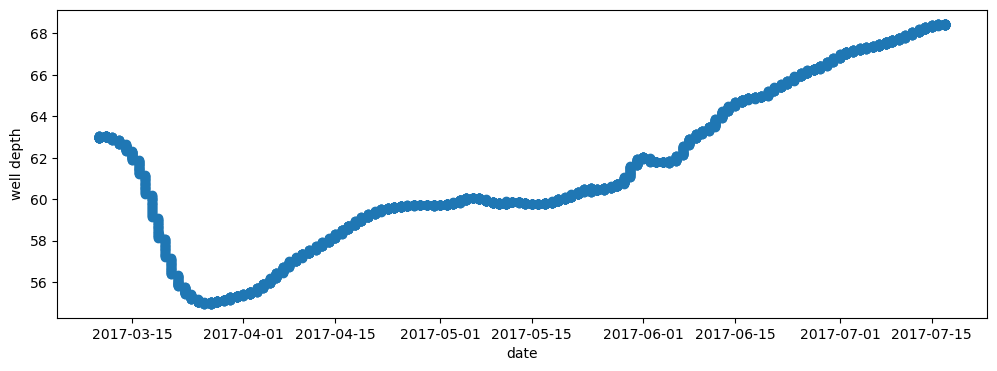

In [15]:
time_delta = timedelta(days=60)
outlier_dates = [[datetime(2008,5,19).date(), datetime(2008,6,26).date()],
                 [datetime(2011,4,9).date(), datetime(2011,4,11).date()],
                 [datetime(2011,5,17).date(), datetime(2011,3,19).date()],
                 [datetime(2012,4,6).date(), datetime(2012,4,10).date()],
                 [datetime(2012,4,24).date(), datetime(2012,5,24).date()],
                 [datetime(2012,6,13).date(), datetime(2012,6,20).date()],
                 [datetime(2017,3,18).date(), datetime(2017,5,4).date()],
                 [datetime(2017,5,8).date(), datetime(2017,5,19).date()]]
for outlier_date in outlier_dates:
    low_date = outlier_date[0]-time_delta
    hi_date = outlier_date[1]+time_delta
    extremes = level_data.loc[(level_data.date > low_date) & (level_data.date < hi_date)]
    plt.figure(figsize=(12,4))
    plt.plot(extremes.date, extremes.well_depth, 'o-')
    plt.xlabel('date')
    plt.ylabel('well depth')
    plt.show()

The outliers all appear to be in line with the nearby data, so they aren't concerning.

In [16]:
## Group measurments recorded on the same date, and compute their average as the daily avg_well_depth
level_data['avg_well_depth'] = level_data.groupby('date')['well_depth'].transform('mean')

In [17]:
## Gather the columns we want, in the order we want
level_data = level_data.drop_duplicates('date')[['date','avg_well_depth']]

# Feature Variables

## Surface Water Data from the USGS

USGS Site No: 12422500 [link](https://waterdata.usgs.gov/nwis/inventory?site_no=12422500)

In [18]:
## Load the raw data
sw_data = pd.read_csv('../data-collection/data/USGS-Surface-Water-Site-12422500.tsv',
                      low_memory=False,
                      delimiter='\t',
                      comment='#')

## Drop meaningless top row
sw_data = sw_data.drop(0, axis=0)

In [19]:
## Grab the columns we want
sw_data = sw_data[['datetime','149640_00060_00003','149641_00065_00003']]

## Rename the columns to something more meaningful
headers = {'datetime':'datetime_recorded', '149640_00060_00003':'discharge_cfs', '149641_00065_00003':'gage_ht'}
sw_data = sw_data.rename(columns=headers)

## Make the column datatypes useful
sw_data['datetime_recorded'] = pd.to_datetime(sw_data['datetime_recorded'])
sw_data['discharge_cfs'] = sw_data['discharge_cfs'].astype(float)
sw_data['gage_ht'] = sw_data['gage_ht'].astype(float)

## Sort the data by the timestamp
sw_data = sw_data.sort_values('datetime_recorded')
sw_data = sw_data.reset_index(drop=True)

In [20]:
## Extract the date as columns from the timestamp
sw_data['date']=sw_data.datetime_recorded.dt.date

# Checking for missing data and outliers

In [21]:
## Looking for NaN Values
sw_data.isna().sum()

datetime_recorded        0
discharge_cfs            0
gage_ht              36750
date                     0
dtype: int64

It looks like gage_ht is missing a ton of values. Lets see where they are...

In [22]:
sw_data['year'] = sw_data['datetime_recorded'].dt.year
sw_data.groupby('year')['gage_ht'].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
1900,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1901,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1902,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1903,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1904,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1905,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1907,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1908,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dealing with missing values

It looks like the years 2001-2004, and 2005-2023 have barely any missing data. That year long gap is kind of an issue, though. We'll just drop everything before 2005 for now, and come back to it if we need it later. For the remain ing missing values, fill with the last non-missing value before the gap

In [23]:
## Restrict our attention to 2005 and beyond for the gage_ht
sw_data_gage_ht = sw_data.loc[sw_data.datetime_recorded>=datetime(2005,1,1)][['date','gage_ht']].copy()
## Fill missing gage_ht values with the last value before the gap
sw_data_gage_ht = sw_data_gage_ht.fillna(method='ffill')

## Keep all of the discharge data
sw_data_discharge_cfs = sw_data[['date','discharge_cfs']].copy()

## Looking for outliers

We'll see how many outliers there are, and if anything sticks out... address it.

In [24]:
sw_data_gage_ht.describe()

,gage_ht
count,6868.000000
mean,19.985243
std,2.245764
min,16.950000
25%,18.310000
50%,19.360000
75%,21.120000
max,28.680000


In [25]:
sw_data_gage_ht.loc[sw_data_gage_ht.gage_ht > 19.985243+ 2*2.235764].count()

date       347
gage_ht    347
dtype: int64

In [26]:
sw_data_gage_ht.loc[sw_data_gage_ht.gage_ht > 19.985243+ 3*2.235764].count()

date       60
gage_ht    60
dtype: int64

In [27]:
sw_data_gage_ht.loc[sw_data_gage_ht.gage_ht > 19.985243+ 3.75*2.235764].count()

date       5
gage_ht    5
dtype: int64

In [28]:
sw_data_gage_ht.loc[sw_data_gage_ht.gage_ht > 19.985243+ 3.5*2.235764]

,date,gage_ht
39295,2008-05-22,28.17
39296,2008-05-23,28.37
39297,2008-05-24,28.32
39298,2008-05-25,28.16
39299,2008-05-26,27.98
39300,2008-05-27,27.83
42519,2017-03-20,28.29
42520,2017-03-21,28.65
42521,2017-03-22,28.68
42522,2017-03-23,28.57


In [29]:
sw_data_gage_ht.loc[sw_data_gage_ht.gage_ht < 19.985243 - 2*2.235764].count()

date       0
gage_ht    0
dtype: int64

It doesn't appear that there are any major outliers to deal with for gage height.

We'll look at discharge rate next.

In [30]:
sw_data_discharge_cfs.describe()

,discharge_cfs
count,44926.000000
mean,6529.655144
std,6660.000498
min,466.000000
25%,1990.000000
50%,3620.000000
75%,8797.500000
max,47100.000000


In [31]:
sw_data_discharge_cfs.loc[sw_data_discharge_cfs.discharge_cfs > 6529.655144 + 4*6660].count()

date             165
discharge_cfs    165
dtype: int64

In [32]:
sw_data_discharge_cfs.loc[sw_data_discharge_cfs.discharge_cfs < 6529.655144 - 2*6660].count()

date             0
discharge_cfs    0
dtype: int64

Nothing too crazy here either... whew!

## Wether Data from NOAA

Using data from the National Oceianic and Atmospheric Administration's (NOAA) National Centers for Environmental Information (NCEI) database, we ordered the following data from Spokane County, WA (FIPS:53063), for the dates 2005-01-01 through 2019-12-31.

Data is provided for several stations. we will use `USW00024157`, which is the weather station at the Spokane airport. We only want the precipitation (`PRCP`) information from this site.

From the documentation, this data is provided as:
> Precipitation - Total Liquid Content (TLC): Water equivalent amount of precipitation for the day (in inches to hundredths). This is all types of precipitation (melted and frozen). T indicates trace amount of precipitation. If left blank, precipitation amount is unreported.

In [33]:
noaa_data = pd.read_csv('../data-collection/data/noaa-data.csv', parse_dates=['DATE'], low_memory=False)
noaa_data['date']=noaa_data.DATE.dt.date
noaa_data = noaa_data.loc[noaa_data.STATION=='USW00024157'][['date','PRCP']].copy()
noaa_data = noaa_data.rename(columns={'PRCP':'prcp'})

We want to check whether our data matches up with annual expectations (~17" on average), so we sum up all of the preciptitation for each year.

In [34]:
noaa_data['year'] = noaa_data.date.apply(lambda x: x.year)

In [35]:
noaa_data.groupby('year')['prcp'].sum()

year
2005    17.38
2006    21.13
2007    13.97
2008    16.28
2009    15.45
2010    19.03
2011    15.40
2012    21.32
2013    11.36
2014    14.99
2015    14.08
2016    18.30
2017    22.34
2018    15.95
2019    15.45
Name: prcp, dtype: float64

Looks good!

Lets see if there are any missing values, or extreme values.

In [36]:
noaa_data.isna().sum()

date    0
prcp    0
year    0
dtype: int64

In [37]:
noaa_data['prcp'].describe()

count    5478.000000
mean        0.046081
std         0.115756
min         0.000000
25%         0.000000
50%         0.000000
75%         0.020000
max         1.330000
Name: prcp, dtype: float64

Looks good!

## Weather Data from Openweather.com

Bulk weather history data is available for purchase [here](https://home.openweathermap.org/marketplace)


In [38]:
## Import raw data
wx_data = pd.read_csv('../data-collection/data/open-weather-spokane.csv')

In [39]:
## Create localized timestamps
def trunc(isodt):
    return isodt[0:-10]

wx_data['dt_iso'] = wx_data['dt_iso'].apply(trunc)

wx_data['dt_iso'] = pd.to_datetime(wx_data['dt_iso'],
                                       utc=True)
wx_data['datetime_recorded'] = wx_data['dt_iso'].dt.tz_convert('US/Pacific')

wx_data = wx_data.sort_values('datetime_recorded')
wx_data = wx_data.reset_index(drop=True)

In [40]:
## Add a date column
wx_data['date'] = wx_data.datetime_recorded.dt.date

In [41]:
## Restrict to the columns of interest
wx_data = wx_data[['date',
                   'temp',
                   'pressure', 
                   'humidity', 
                   'wind_speed',
                   'wind_gust', 
                   'rain_1h',
                   'snow_1h',]].copy()

## Checking for missing values and outliers

In [42]:
wx_data.isna().sum()

date               0
temp               0
pressure           0
humidity           0
wind_speed         0
wind_gust     378013
rain_1h       362402
snow_1h       401305
dtype: int64

It looks like we're only missing entried in `wind_gust`, `rain_1h`, and `snow_1h`. Manual inspacetion of the data seems to indicate that null valued correspond to zeros.

In [43]:
wx_data[215:255]

,date,temp,pressure,humidity,wind_speed,wind_gust,rain_1h,snow_1h
215,1979-01-09,17.08,1025,56,0.00,NaN,NaN,NaN
216,1979-01-09,15.82,1026,73,5.82,NaN,NaN,NaN
217,1979-01-09,14.88,1031,82,2.59,NaN,NaN,NaN
218,1979-01-09,16.11,1031,83,3.36,NaN,NaN,NaN
219,1979-01-09,17.47,1024,70,11.41,NaN,NaN,NaN
220,1979-01-09,17.44,1030,85,3.40,NaN,NaN,NaN
221,1979-01-09,16.07,1025,67,4.47,NaN,NaN,NaN
222,1979-01-09,19.63,1024,70,6.71,NaN,NaN,NaN
223,1979-01-09,16.32,1024,64,5.59,NaN,NaN,NaN
224,1979-01-10,17.42,1023,73,10.29,NaN,NaN,NaN


In [44]:
wx_data[4035:4050]

,date,temp,pressure,humidity,wind_speed,wind_gust,rain_1h,snow_1h
4035,1979-06-03,58.77,1010,50,3.11,NaN,NaN,NaN
4036,1979-06-03,69.46,1013,36,0.00,NaN,NaN,NaN
4037,1979-06-03,73.78,1010,43,0.00,NaN,NaN,NaN
4038,1979-06-03,77.81,1009,27,4.79,NaN,NaN,NaN
4039,1979-06-03,80.20,1013,27,6.71,NaN,NaN,NaN
4040,1979-06-03,82.04,1012,26,6.71,NaN,NaN,NaN
4041,1979-06-03,83.43,1012,23,11.41,NaN,NaN,NaN
4042,1979-06-03,84.27,1012,18,16.11,20.58,NaN,NaN
4043,1979-06-03,87.03,1011,19,16.11,22.82,NaN,NaN
4044,1979-06-03,86.95,1011,19,14.76,20.58,NaN,NaN


In [45]:
wx_data[6000:6020]

,date,temp,pressure,humidity,wind_speed,wind_gust,rain_1h,snow_1h
6000,1979-08-23,81.52,1013,35,6.71,NaN,NaN,NaN
6001,1979-08-23,82.56,1013,37,10.29,NaN,NaN,NaN
6002,1979-08-23,75.04,1013,50,26.40,41.38,NaN,NaN
6003,1979-08-23,73.99,1013,43,20.58,29.75,0.11,NaN
6004,1979-08-23,73.09,1014,42,11.41,NaN,0.11,NaN
6005,1979-08-23,71.55,1014,48,10.29,NaN,NaN,NaN
6006,1979-08-23,68.49,1015,57,11.41,NaN,0.26,NaN
6007,1979-08-23,68.49,1016,59,11.63,NaN,2.41,NaN
6008,1979-08-23,68.49,1016,59,11.63,NaN,2.41,NaN
6009,1979-08-24,66.24,1018,65,8.05,NaN,0.94,NaN


In [46]:
## Fill NaN values with zeros
wx_data = wx_data.fillna(0)

## Looking for outliers

In [47]:
wx_data.temp.describe()

count    416391.000000
mean         49.343083
std          33.075015
min      -17964.980000
25%          35.850000
50%          47.610000
75%          61.680000
max         109.890000
Name: temp, dtype: float64

In [48]:
wx_data.loc[wx_data.temp < -20]

,date,temp,pressure,humidity,wind_speed,wind_gust,rain_1h,snow_1h
10,1979-01-01,-21.62,1053,78,4.45,0.0,0.0,0.0
11,1979-01-01,-20.15,1046,62,0.00,0.0,0.0,0.0
12,1979-01-01,-20.29,1044,72,3.36,0.0,0.0,0.0
13,1979-01-01,-20.20,1044,72,4.47,0.0,0.0,0.0
14,1979-01-01,-21.30,1054,74,3.58,0.0,0.0,0.0
287040,2009-12-07,-17964.98,1020,0,5.06,0.0,0.0,0.0


Yikes! Thats one cold day... Let's fill that in with the temp that came before it...

In [49]:
wx_data.loc[wx_data.date==datetime(2009,12,7).date()]

,date,temp,pressure,humidity,wind_speed,wind_gust,rain_1h,snow_1h
287019,2009-12-07,12.58,1019,31,23.04,32.21,0.0,0.0
287020,2009-12-07,12.58,1022,30,20.80,27.51,0.0,0.0
287021,2009-12-07,12.09,1019,29,19.69,27.74,0.0,0.0
287022,2009-12-07,12.09,1019,30,18.34,24.16,0.0,0.0
287023,2009-12-07,11.59,1021,32,19.46,0.00,0.0,0.0
287024,2009-12-07,11.59,1018,33,14.99,24.16,0.0,0.0
287025,2009-12-07,11.01,1018,35,14.99,0.00,0.0,0.0
287026,2009-12-07,10.60,1021,34,17.22,0.00,0.0,0.0
287027,2009-12-07,11.01,1018,33,12.75,0.00,0.0,0.0
287028,2009-12-07,12.58,1018,32,14.99,21.92,0.0,0.0


In [50]:
wx_data.loc[287040,'temp']=10.09

In [51]:
wx_data.pressure.describe()

count    416391.000000
mean       1015.911583
std           7.298607
min         981.000000
25%        1011.000000
50%        1016.000000
75%        1020.000000
max        1054.000000
Name: pressure, dtype: float64

In [52]:
wx_data.humidity.describe()

count    416391.000000
mean         66.645511
std          23.010471
min           0.000000
25%          48.000000
50%          71.000000
75%          87.000000
max         100.000000
Name: humidity, dtype: float64

In [53]:
wx_data.wind_speed.describe()

count    416391.000000
mean          9.099076
std           5.262341
min           0.000000
25%           5.790000
50%           8.050000
75%          11.630000
max          57.490000
Name: wind_speed, dtype: float64

In [54]:
wx_data.wind_gust.describe()

count    416391.000000
mean          1.796953
std           6.915414
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          79.410000
Name: wind_gust, dtype: float64

In [55]:
'''
Compute the following:
`temp_avg`, `temp_max`, `temp_min`, 
`hPa_avg`, 
`hum_avg`, `hum_max`, `hum_min`,
`wind_avg`, `wind_max`, `wind_min`, 
`gust_avg`, `gust_max`, `gust_min`
''' 
wx_data['temp_avg'] = wx_data.groupby('date')['temp'].transform('mean')
wx_data['temp_max'] = wx_data.groupby('date')['temp'].transform('max')
wx_data['temp_min'] = wx_data.groupby('date')['temp'].transform('min')
wx_data['hPa_avg'] = wx_data.groupby('date')['pressure'].transform('mean')
wx_data['hum_avg'] = wx_data.groupby('date')['humidity'].transform('mean')
wx_data['hum_max'] = wx_data.groupby('date')['humidity'].transform('max')
wx_data['hum_min'] = wx_data.groupby('date')['humidity'].transform('min')
wx_data['wind_avg'] = wx_data.groupby('date')['wind_speed'].transform('mean')
wx_data['wind_max'] = wx_data.groupby('date')['wind_speed'].transform('max')
wx_data['wind_min'] = wx_data.groupby('date')['wind_speed'].transform('min')
wx_data['gust_avg'] = wx_data.groupby('date')['wind_gust'].transform('mean')
wx_data['gust_max'] = wx_data.groupby('date')['wind_gust'].transform('max')
wx_data['gust_min'] = wx_data.groupby('date')['wind_gust'].transform('min')

In [56]:
wx_data = wx_data.drop_duplicates('date')[['date',
                                               'temp_avg', 'temp_max', 'temp_min', 
                                               'hPa_avg',
                                               'hum_avg', 'hum_max', 'hum_min', 
                                               'wind_avg', 'wind_max', 'wind_min', 
                                               'gust_avg', 'gust_max', 'gust_min']].copy()